In [1]:
import math
import os
import sys
sys.path.insert(0,'../src/')
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
from database import SQLiteDatabase
from experiment import preliminary_setup
import query

In [103]:
KWARGS = preliminary_setup()
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
register_matplotlib_converters()
DB_DIRECTORY = KWARGS['database_directory']
FIGURES_DIRECTORY = KWARGS['figure_directory']
DATABASE = SQLiteDatabase(os.path.join(DB_DIRECTORY,'deployment_strategy_2_0.db'))

RBC_REFERENCE_LOAD_SUMMARY = pd.read_csv(os.path.join(KWARGS['summary_directory'], 'rbc_reference_1_load_summary.csv'))

RBC_REFERENCE_COST_SUMMARY = pd.read_csv(os.path.join(KWARGS['summary_directory'], 'rbc_reference_1_cost_summary.csv'))
RBC_REFERENCE_COST_SUMMARY = RBC_REFERENCE_COST_SUMMARY.rename(columns={'building_id': 'deployment_building_id'})
RBC_REFERENCE_COST_SUMMARY['agent_building_id'] = RBC_REFERENCE_COST_SUMMARY['deployment_building_id']

NO_TRANSFER_COST_SUMMARY = pd.read_csv(os.path.join(KWARGS['summary_directory'], 'deployment_strategy_1_0_cost_summary.csv'))
NO_TRANSFER_COST_SUMMARY = NO_TRANSFER_COST_SUMMARY.rename(columns={'building_id': 'deployment_building_id'})
NO_TRANSFER_COST_SUMMARY['agent_building_id'] = NO_TRANSFER_COST_SUMMARY['deployment_building_id']

GRID = DATABASE.get_table('grid')
GRID = GRID.rename(columns={'building':'deployment_building_id'})
GRID['deployment_building_id'] = GRID['deployment_building_id'].str.split('_', expand=True)[1].astype(int)

# Building-Level Scores

In [3]:
building_cost_data = DATABASE.query_table(query.get_building_cost_summary())
building_cost_data = building_cost_data.rename(columns={'building_id':'agent_building_id'})
grid = GRID[['deployment_building_id', 'simulation_group']].drop_duplicates()
building_cost_data = grid.merge(building_cost_data, on='simulation_group', how='left')

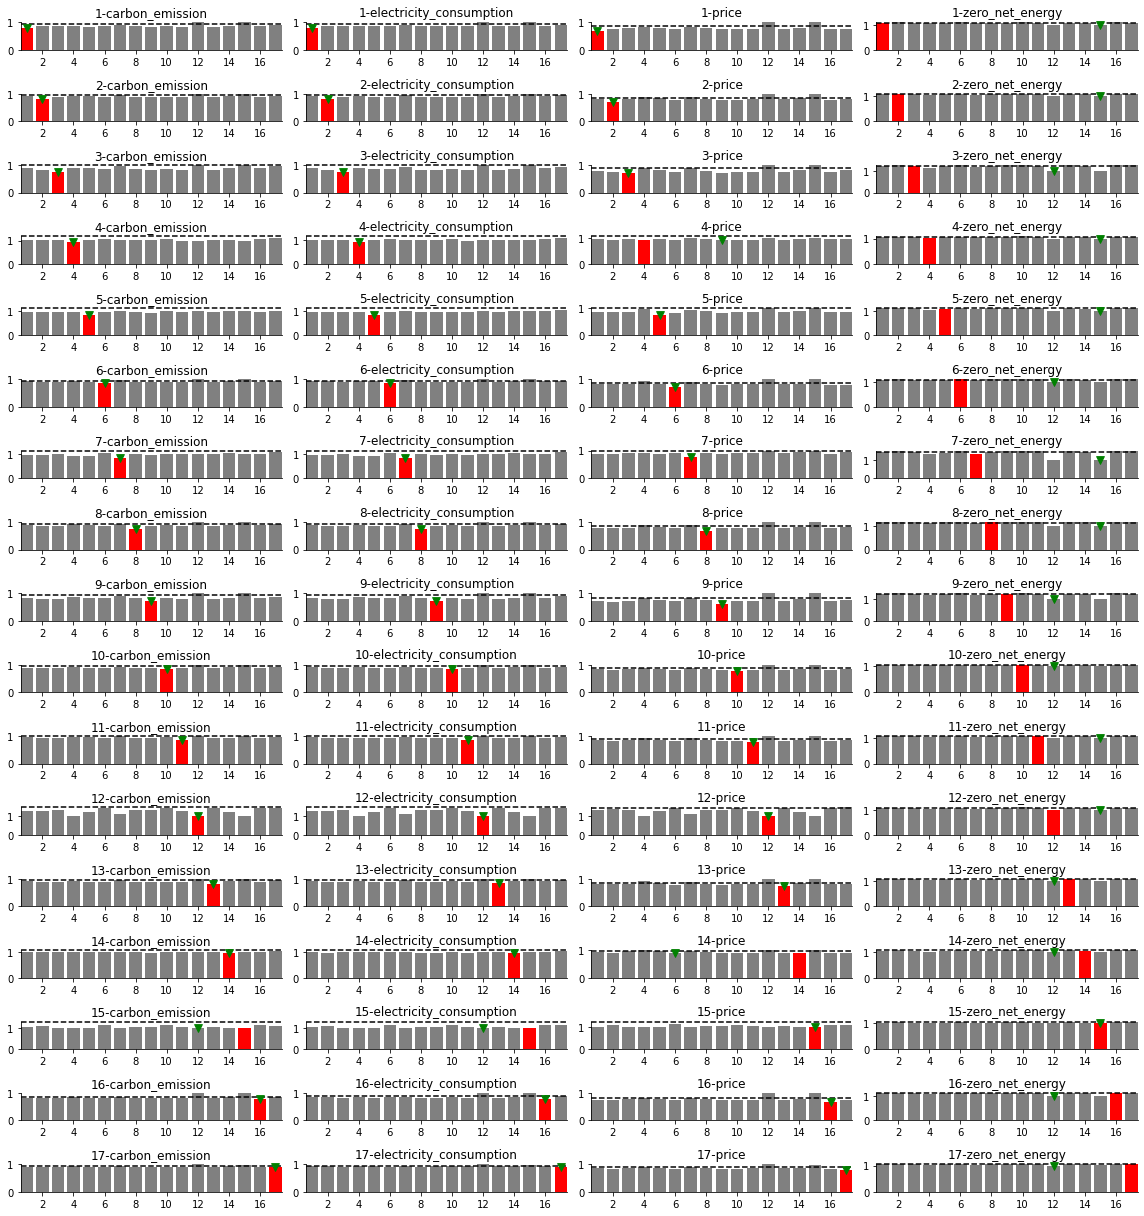

In [106]:
costs = ['zero_net_energy', 'price', 'electricity_consumption', 'carbon_emission']
row_count = len(building_cost_data['deployment_building_id'].unique())
column_count = len(costs)
cmap = 'coolwarm'
plot_data = building_cost_data[
    (building_cost_data['episode']==building_cost_data['episode'].max())
    &(building_cost_data['cost'].isin(costs))
].copy()
tf_plot_data = plot_data.sort_values(['agent_building_id'])
fig, ax = plt.subplots(row_count, column_count, figsize=(4*column_count,1.0*row_count), sharex=False, sharey=False)

for i, (ax, ((b, c), c_data)) in enumerate(zip(fig.axes, tf_plot_data.groupby(['deployment_building_id', 'cost']))):
    colors = ['grey']*c_data.shape[0]
    colors[b - 1] = 'red'
    x, y = c_data['agent_building_id'].tolist(), c_data['value'].tolist()
    mini_ixs = [i for i in  range(len(x)) if y[i] == min(y)]
    patches = ax.bar(x, y, color=colors)
    rbc_value = RBC_REFERENCE_COST_SUMMARY[
        (RBC_REFERENCE_COST_SUMMARY['agent_building_id']==b) 
        & (RBC_REFERENCE_COST_SUMMARY['cost']==c)
    ]['value'].iloc[0]
    ax.axhline(rbc_value, linestyle='--', color='black', clip_on=False)
    ax.set_title(f'{b}-{c}')
    ax.tick_params('x', which='both', rotation=0)

    for i in mini_ixs:
        b_x, b_y = [i + 1], [y[i]]
        ax.scatter(b_x, b_y, color='green', clip_on=False, marker='v', zorder=100, s=60)

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIRECTORY,f'deployment_strategy_2_0_building_cost_summary.pdf'),bbox_inches='tight',transparent=True)
plt.show()

- maybe small multiples of bar plots will show the data better?
- What is going on with building 7 having really low ZNE on transfer even lower than it's self trained model?
- How do these buildings actually compare; what are their similarities? Cluster their daily profile?
- If what i have plotted and simulated is correct, you get similar performance if you

Summary grouping: agent_building_id


,cost,agent_building_id,mean,std,polarity
0,price,1,0.180516,0.142470,+
1,price,2,0.155380,0.169087,+
2,price,3,0.181405,0.146124,+
3,price,4,-0.008511,0.062355,-
4,price,5,0.127575,0.123989,+
5,price,6,0.131258,0.182619,+
6,price,7,0.138338,0.081696,+
7,price,8,0.208863,0.146044,+
8,price,9,0.238909,0.155786,+
9,price,10,0.106527,0.184746,+


mean             std          
                         count      mean count      mean
cost            polarity                                
price           +           14  0.142516    14  0.145000
                -            3 -0.005006     3  0.062559
zero_net_energy +           12  0.044802    12  0.091953
                -            5 -0.114192     5  0.099449

Summary grouping: deployment_building_id


,cost,deployment_building_id,mean,std,polarity
0,price,1,0.117230,0.077182,+
1,price,2,0.129634,0.072167,+
2,price,3,0.117811,0.086737,+
3,price,4,0.031583,0.027643,+
4,price,5,0.124345,0.058945,+
5,price,6,0.117954,0.065286,+
6,price,7,0.136386,0.038509,+
7,price,8,0.149415,0.075504,+
8,price,9,0.160329,0.095707,+
9,price,10,0.083149,0.059392,+


mean             std          
                         count      mean count      mean
cost            polarity                                
price           +           17  0.116482    17  0.068378
zero_net_energy +            5  0.035298     5  0.049597
                -           12 -0.017485    12  0.044320

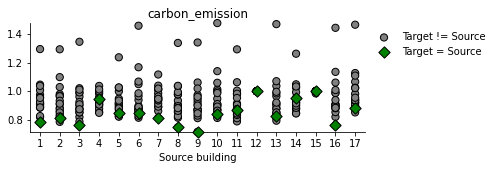

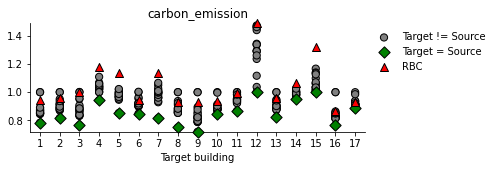

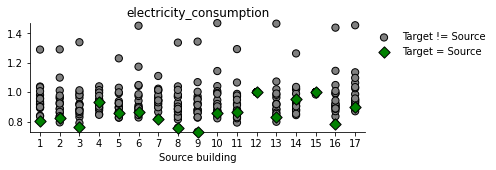

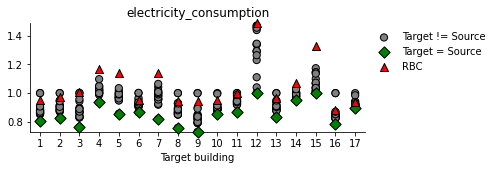

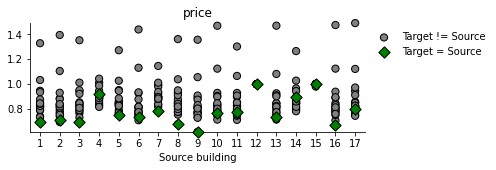

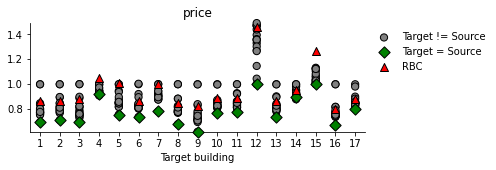

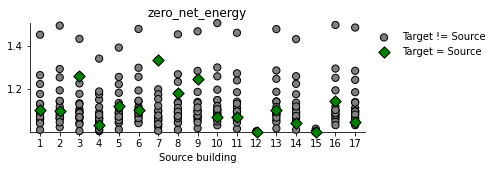

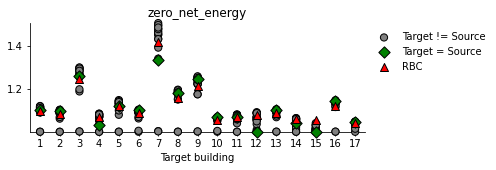

In [202]:
row_count = 1
column_count = 1
marker_size = 8
edgecolor = 'black'
linewidth = 1


group_columns = ['agent_building_id', 'deployment_building_id']

for c in group_columns:
    summary_data = tf_plot_data[
        (tf_plot_data['cost'].isin(['price', 'zero_net_energy']))
        # (~tf_plot_data['deployment_building_id'].isin([12, 15])) 
        # & (~tf_plot_data['agent_building_id'].isin([12, 15]))
    ].copy()
    self_data = summary_data[(summary_data['deployment_building_id'] == summary_data['agent_building_id'])].copy()
    self_data = self_data.rename(columns={'value': 'ref_value'})
    summary_data = summary_data.drop(self_data.index)
    rbc_data = RBC_REFERENCE_COST_SUMMARY.copy()
    rbc_data = rbc_data.rename(columns={'value': 'rbc_value'})
    summary_data = summary_data.merge(self_data[['cost', 'ref_value', c]], on=['cost', c], how='left')
    summary_data = summary_data.merge(rbc_data[['cost', 'rbc_value', 'deployment_building_id']], on=['cost', 'deployment_building_id'], how='left')
    negative_transfer_summary = summary_data.copy()
    negative_transfer_summary['difference'] = negative_transfer_summary['value'] - negative_transfer_summary['rbc_value']
    negative_transfer_summary['polarity'] = negative_transfer_summary['difference']/negative_transfer_summary['difference'].abs()
    negative_transfer_summary = negative_transfer_summary.groupby(['cost', 'deployment_building_id', 'polarity']).size().reset_index(name='count')
    summary_data['difference'] = summary_data['value'] - summary_data['ref_value']
    summary_data = summary_data.groupby(['cost', c,])[['difference']].agg(['mean', 'std'])
    summary_data.columns = ['mean', 'std']
    summary_data = summary_data.reset_index()
    summary_data['polarity'] = '+'
    summary_data.loc[summary_data['mean'] < 0, 'polarity'] = '-'
    summary_data.loc[summary_data['mean'] == 0, 'polarity'] = ':'
    average_summary_data = summary_data.groupby(['cost', 'polarity'])[['mean', 'std']].agg(['count', 'mean'])
    print('Summary grouping:', c)
    # display(negative_transfer_summary)
    display(summary_data)
    display(average_summary_data)

for c, c_data in tf_plot_data.groupby(['cost']):
    for x, t in zip(['agent', 'deployment'], ['Source', 'Target']):
        d_c_data = c_data[c_data['deployment_building_id'] == c_data['agent_building_id']][[
            'deployment_building_id', 'value'
        ]].copy()
        rbc_data = RBC_REFERENCE_COST_SUMMARY[(RBC_REFERENCE_COST_SUMMARY['cost']==c)].copy()
        fig, ax = plt.subplots(row_count, column_count, figsize=(6*column_count, 2.0*row_count))
        sns.stripplot(x=f'{x}_building_id', y='value', data=c_data, ax=ax, color='grey', jitter=False, clip_on=False, size=marker_size*0.9, edgecolor=edgecolor, linewidth=linewidth, label='Target != Source')
        sns.stripplot(x='deployment_building_id', y='value', data=d_c_data,  ax=ax, color='green', jitter=False, clip_on=False, size=marker_size, edgecolor=edgecolor, linewidth=linewidth, marker='D', label='Target = Source')

        if x == 'deployment':
            rbc = sns.stripplot(x='agent_building_id', y='value', data=rbc_data, ax=ax, color='red', jitter=False, clip_on=False, size=marker_size, edgecolor=edgecolor, linewidth=linewidth, marker='^', label='RBC')
        else:
            pass

        for s in ['right','top']:
            ax.spines[s].set_visible(False)

        ax.set_xlabel(f'{t} building')
        ax.set_ylabel(None)
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        ax.legend(bbox_to_anchor=(1.0,1.0), loc='upper left', framealpha=0, ncol=1, *zip(*unique))
        building_ids = sorted(c_data[f'{x}_building_id'].unique().tolist())
        ax.xaxis.set_major_locator(ticker.FixedLocator([i - 1 for i in building_ids]))
        ax.set_xticklabels(building_ids)
        ax.set_title(c)

        plt.savefig(os.path.join(FIGURES_DIRECTORY,f'deployment_strategy_2_0_{t.lower()}_building_{c}_cost_summary.pdf'),bbox_inches='tight',transparent=True)
        plt.show()

carbon_emission


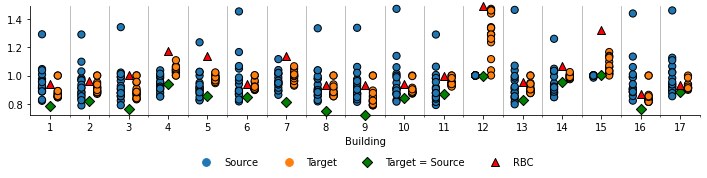

electricity_consumption


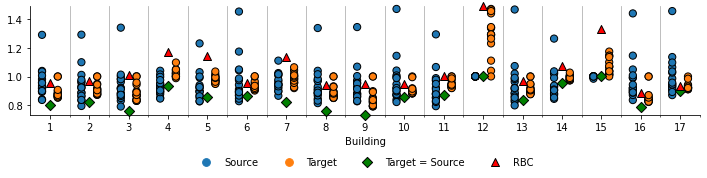

price


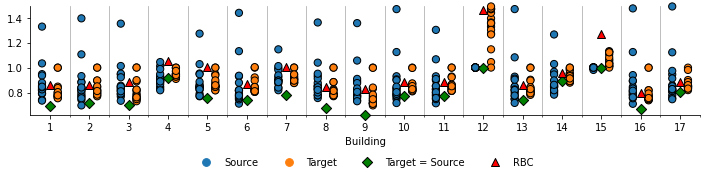

zero_net_energy


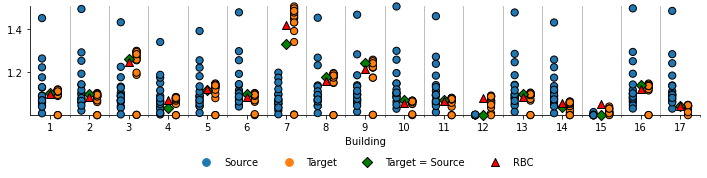

In [105]:
row_count = 1
column_count = 1
marker_size = 8
edgecolor = 'black'
linewidth = 1

for c, c_data in tf_plot_data.groupby(['cost']):
    print(c)
    d_c_data = c_data[c_data['deployment_building_id'] == c_data['agent_building_id']][[
        'deployment_building_id', 'value'
    ]].copy()
    s_data = c_data.drop(d_c_data.index)[['agent_building_id', 'value']].copy()
    s_data = s_data.rename(columns={'agent_building_id': 'building_id'})
    s_data['label'] = 'Source'
    t_data = c_data.drop(d_c_data.index)[['deployment_building_id', 'value']].copy()
    t_data = t_data.rename(columns={'deployment_building_id': 'building_id'})
    t_data['label'] = 'Target'
    c_data = pd.concat([s_data, t_data], ignore_index=True, sort=False)
    rbc_data = RBC_REFERENCE_COST_SUMMARY[(RBC_REFERENCE_COST_SUMMARY['cost']==c)].copy()
    
    fig, ax = plt.subplots(row_count, column_count, figsize=(12*column_count, 2.0*row_count))
    sns.stripplot(x=f'building_id', y='value', data=c_data, ax=ax, hue='label', jitter=False, dodge=True, clip_on=False, size=marker_size*0.9, edgecolor=edgecolor, linewidth=linewidth)
    sns.stripplot(x='deployment_building_id', y='value', data=d_c_data,  ax=ax, color='green', jitter=False, clip_on=False, size=marker_size*0.9, edgecolor=edgecolor, linewidth=linewidth, marker='D', label='Target = Source')

    if x == 'deployment':
        sns.stripplot(x='agent_building_id', y='value', data=rbc_data, ax=ax, color='red', jitter=False, clip_on=False, size=marker_size, edgecolor=edgecolor, linewidth=linewidth, marker='^', label='RBC')
    else:
        pass

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    ax.set_xlabel(f'Building')
    ax.set_ylabel(None)
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(bbox_to_anchor=(0.5, -0.3), loc='upper center', framealpha=0, ncol=4, *zip(*unique))
    building_ids = sorted(c_data[f'building_id'].unique().tolist())
    ax.xaxis.set_major_locator(ticker.FixedLocator([i - 1 for i in building_ids]))
    ax.set_xticklabels(building_ids)
    ax.set_xticks([i - 0.5 for i in building_ids], minor=True)
    ax.grid(visible=True, which='minor', axis='x')

    # plt.savefig(os.path.join(FIGURES_DIRECTORY,f'deployment_strategy_2_0_{t.lower()}_building_{c}_cost_summary.pdf'),bbox_inches='tight',transparent=True)
    plt.show()
    # assert False

# District-Level Scores

In [110]:
district_cost_data = DATABASE.query_table(query.get_transfer_learning_district_cost_summary())

difference                              
                               min       max      mean       std
cost                                                            
carbon_emission           0.075944  0.151503  0.102050  0.025147
daily_peak                0.027352  0.244611  0.098417  0.061706
electricity_consumption   0.069257  0.144259  0.095884  0.026284
load_factor              -0.001707  0.047961  0.026366  0.015509
price                     0.063711  0.220734  0.109828  0.045231
ramping                   0.210113  0.448094  0.286935  0.067934
zero_net_energy          -0.113279  0.030578 -0.002038  0.044180

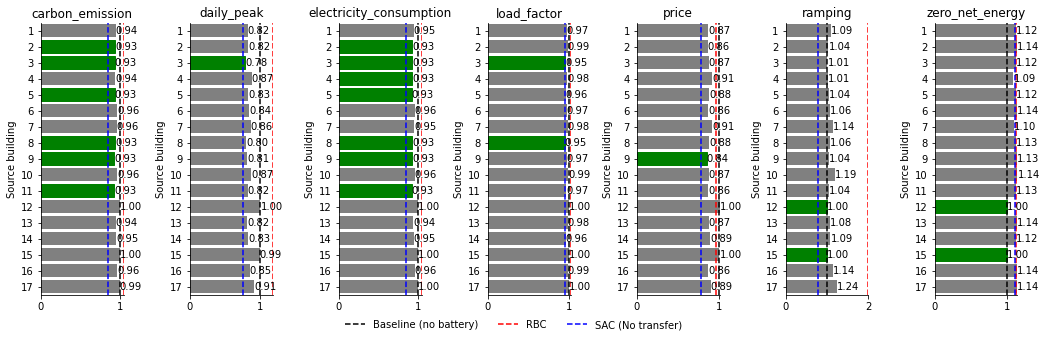

In [213]:
column_count_limit = 8
costs = district_cost_data['cost'].unique()
row_count = math.ceil(len(costs)/column_count_limit)
column_count = min(column_count_limit, len(costs))
fig, _ = plt.subplots(row_count, column_count, figsize=(column_count*2.5, row_count*5.0), gridspec_kw={'wspace': 0.8})
plot_data = district_cost_data[district_cost_data['episode']==district_cost_data['episode'].max()].copy()
plot_data['agent'] = 'SAC'
summary_data = plot_data.copy()
no_transfer_data = NO_TRANSFER_COST_SUMMARY[
    (NO_TRANSFER_COST_SUMMARY['episode']==NO_TRANSFER_COST_SUMMARY['episode'].max()) & (NO_TRANSFER_COST_SUMMARY['scope']=='district')
].copy()
no_transfer_data = no_transfer_data.rename(columns={'value': 'no_transfer_value'})
summary_data = summary_data.merge(no_transfer_data[['cost', 'no_transfer_value']], on=['cost'], how='left')
summary_data['difference'] = summary_data['value'] - summary_data['no_transfer_value']
summary_data = summary_data.groupby(['cost'])[['difference']].agg(['min', 'max', 'mean', 'std'])
display(summary_data)

for i, (ax, (c, c_data)) in enumerate(zip(fig.axes, plot_data.groupby('cost'))):
    c_data = c_data.sort_values('source_building_id')
    c_data['source_building_id'] = c_data['source_building_id'].astype(str)
    sns.barplot(x='value', y='source_building_id', data=c_data, ax=ax, color='grey')
    rbc_value = RBC_REFERENCE_COST_SUMMARY[
        (RBC_REFERENCE_COST_SUMMARY['cost']==c) & (RBC_REFERENCE_COST_SUMMARY['scope']=='district')
    ]['value'].iloc[0]
    no_transfer_value = NO_TRANSFER_COST_SUMMARY[
        (NO_TRANSFER_COST_SUMMARY['episode']==NO_TRANSFER_COST_SUMMARY['episode'].max()) & (NO_TRANSFER_COST_SUMMARY['cost']==c) & (NO_TRANSFER_COST_SUMMARY['scope']=='district')
    ]['value'].iloc[0]
    ax.axvline(1.0, color='black', linestyle='--', label='Baseline (no battery)')
    ax.axvline(rbc_value, color='red', linestyle='--', label='RBC')
    ax.axvline(no_transfer_value, color='blue', linestyle='--', label='SAC (No transfer)')
    ax.set_xlabel(None)
    ax.set_ylabel('Source building')
    ax.set_title(c)

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    for j, p in enumerate(ax.patches):
        ax.text(p.get_x() + p.get_width(), p.get_y() + p.get_height()/2.0, f'{p.get_width():0.2f}', ha='left', va='center')

        if round(p.get_width(), 2) == c_data['value'].round(2).min():
            # p.set_hatch('/')
            p.set_color('green')
        else:
            pass
    
    if i == len(costs) - 1:
        ax.legend(
            bbox_to_anchor=(0.5, 0.08),
            loc='upper center', 
            bbox_transform=fig.transFigure,
            framealpha=0,
            ncol=3
        )
    else:
        pass

plt.savefig(os.path.join(FIGURES_DIRECTORY,f'deployment_strategy_2_0_district_cost_summary.pdf'),bbox_inches='tight',transparent=True)
# plt.tight_layout()
plt.show()


# Save

In [5]:
building_cost_data['scope'] = 'building'
pd.concat([building_cost_data,], ignore_index=True, sort=False).to_csv(
    os.path.join(KWARGS['summary_directory'], 'deployment_strategy_2_0_cost_summary.csv'), index=False
)